In [1]:
import yfinance as yf
import pandas as pd
from datetime import date
from time import sleep
from glob import glob
import os
import json
import matplotlib.pyplot as plt
from yfetch import get_stock_history

In [2]:
def load_call(symbol, expiration):
    dir = f'data/options/{symbol}/{expiration}'

    with open(f'{dir}/underlying.json', 'r') as f:
        underlying = json.load(f)
    stock_price = underlying.get('regularMarketPrice')
    assert stock_price, f'Invalid stock price data for {symbol} on {expiration}'

    calls_file = f'{dir}/calls.csv'
    calls = pd.read_csv(calls_file)
    itm = calls[calls['inTheMoney'] == True]
    assert not itm.empty, f'No ITM calls for {symbol} on {expiration}'
    otm = calls[calls['inTheMoney'] == False]
    assert not otm.empty, f'No OTM calls for {symbol} on {expiration}'
    assert itm.iloc[-1].strike <= stock_price <= otm.iloc[0].strike, \
        f'Last stock price {stock_price} for {symbol} is not between ITM and OTM strikes on {expiration}'

    call = otm.iloc[0]  # Get the first OTM call strike
    call_price = max(call.lastPrice, (call.bid + call.ask) / 2)
    assert call_price, f'Invalid call price data for {symbol} on {expiration}'
    assert call.strike, f'Invalid call strike data for {symbol} on {expiration}'

    return underlying['longName'], stock_price, call.strike, call_price

def test_options(symbol, expiration):
    stock_name, stock_price, call_strike, call_price = load_call(symbol, expiration)
    rcp = call_price / call_strike  # relative call price
    gap = call_strike / stock_price - 1

    history = get_stock_history(symbol, period='5y', interval='1wk').tail(114)
    change = history['Close'].pct_change(periods=1).dropna()
    history['change'] = change
    call_profit = ((change - gap) / rcp - 1).clip(lower=-1)
    history['call_profit'] = call_profit

    return {
        'symbol': symbol,
        'name': stock_name,
        'expiration': expiration,
        'weeks': len(history),
        'gap': gap,
        'rcp': rcp,
        'mean_profit': call_profit.mean(),
        'median_profit': call_profit.median(),
        'mean_change': change.mean(),
        'median_change': change.median(),
        'history': history,
        'call_profit': call_profit,
    }

In [3]:
expirations = [
  '2025-05-30', 
  '2025-06-06', 
  '2025-06-13', 
  '2025-06-20', 
  '2025-06-27', 
  '2025-07-03', 
  '2025-07-11', 
  '2025-07-18', 
  '2025-07-25'
]

In [4]:
# results = [ test_options('TQQQ', x) for x in expirations ]
# df = pd.DataFrame(results)#.sort_values('mean_profit', ascending=False).reset_index(drop=True)
# # df.index += 1
# for col in ['rcp', 'gap', 'mean_profit', 'median_profit', 'mean_change', 'median_change']:
#     df[col] = df[col].map('{:.2%}'.format)
# display(df)


In [5]:
from itertools import pairwise

def list_real_calls(symbol):
    rows = []
    for start, end in pairwise(expirations):
        stock_name, start_stock_price, call_strike, start_call_price = load_call(symbol, start)
        _, end_stock_price, _, _ = load_call(symbol, end)

        stock_change = end_stock_price / start_stock_price - 1
        end_call_price = max(0, end_stock_price - call_strike)
        call_profit = end_call_price / start_call_price - 1
        rcp = start_call_price / call_strike  # relative call price
        gap = call_strike / start_stock_price - 1
        rows.append({
            'date': start,
            'stock_change': stock_change,
            'call_profit': call_profit,
            'rcp': rcp,
            'gap': gap,
        })
    return pd.DataFrame(rows).set_index('date')

def display_real_calls(symbol):
    df = list_real_calls(symbol)
    for col in ['rcp', 'gap', 'stock_change', 'call_profit']:
        df[col] = df[col].map('{:.2%}'.format)
    display(df)


In [6]:
from symbols import etfs_with_weekly_options

rows = []
for symbol in etfs_with_weekly_options:
  df = list_real_calls(symbol)
  rows.append({
      'symbol': symbol,
      'mean_call_profit': df['call_profit'].mean(),
      'median_call_profit': df['call_profit'].median(),
      'mean_stock_change': df['stock_change'].mean(),
      'median_stock_change': df['stock_change'].median(),
  })
df = pd.DataFrame(rows).set_index('symbol')
df['MM'] = (df['mean_call_profit']+1) * (df['median_call_profit']+1) - 1
df = df.sort_values('MM', ascending=False)
for col in ['mean_call_profit', 'median_call_profit', 'mean_stock_change', 'median_stock_change', 'MM']:
    df[col] = df[col].map('{:.2%}'.format)
display(df)

,mean_call_profit,median_call_profit,mean_stock_change,median_stock_change,MM
symbol,,,,,
JETS,69.42%,62.50%,1.73%,2.99%,175.30%
XLK,61.83%,43.86%,1.78%,1.89%,132.81%
QQQ,38.97%,59.08%,1.23%,1.38%,121.08%
TQQQ,42.97%,47.79%,3.51%,3.89%,111.30%
ARKK,91.16%,-0.80%,4.20%,2.45%,89.64%
...,...,...,...,...,...
TSLL,-37.52%,-100.00%,-0.93%,-1.45%,-100.00%
SPXU,-98.61%,-100.00%,-2.93%,-3.12%,-100.00%
IAU,-17.87%,-100.00%,-0.03%,0.12%,-100.00%


<Axes: title={'center': '1w Call Performance'}, xlabel='date'>

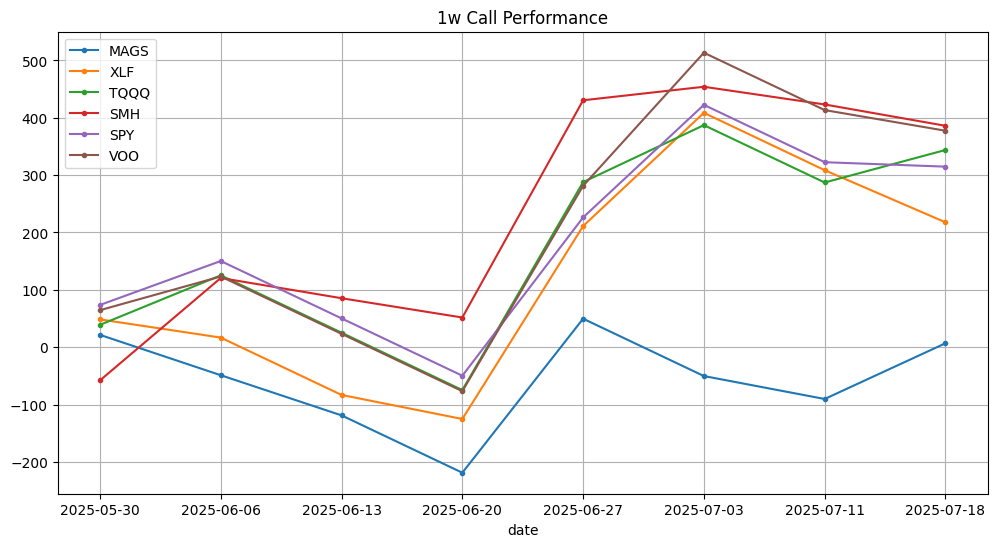

In [7]:
df = pd.DataFrame()
for symbol in ['MAGS', 'XLF', 'TQQQ', 'SMH', 'SPY', 'VOO']:
    df[symbol] = list_real_calls(symbol)['call_profit'].cumsum() * 100  # Convert to percentage
df.plot(title='1w Call Performance', figsize=(12, 6), marker='.', grid=True)

In [8]:
display_real_calls('MAGS')

,stock_change,call_profit,rcp,gap
date,,,,
2025-05-30,2.37%,21.43%,1.36%,0.70%
2025-06-06,0.67%,-70.37%,1.29%,0.29%
2025-06-13,0.85%,-70.00%,0.94%,0.57%
2025-06-20,-0.55%,-100.00%,0.65%,1.60%
2025-06-27,5.15%,268.57%,1.32%,0.26%
2025-07-03,0.63%,-100.00%,0.49%,0.76%
2025-07-11,0.55%,-40.00%,0.71%,0.13%
2025-07-18,1.69%,97.14%,0.62%,0.46%


In [9]:
display_real_calls('XLF')

,stock_change,call_profit,rcp,gap
date,,,,
2025-05-30,1.82%,48.39%,0.61%,0.90%
2025-06-06,0.63%,-31.71%,0.80%,0.08%
2025-06-13,-2.57%,-100.00%,0.66%,0.43%
2025-06-20,0.80%,-41.94%,1.24%,0.08%
2025-06-27,3.14%,336.36%,0.65%,0.28%
2025-07-03,2.41%,197.50%,0.77%,0.12%
2025-07-11,-1.94%,-100.00%,0.62%,0.58%
2025-07-18,0.73%,-90.91%,0.84%,0.65%


In [10]:
display_real_calls('TQQQ')

,stock_change,call_profit,rcp,gap
date,,,,
2025-05-30,5.55%,38.89%,3.22%,1.03%
2025-06-06,6.01%,86.28%,3.23%,0.00%
2025-06-13,-1.86%,-100.00%,2.23%,1.06%
2025-06-20,-0.52%,-100.00%,3.05%,0.23%
2025-06-27,12.38%,362.64%,2.49%,0.76%
2025-07-03,4.16%,99.29%,1.72%,0.71%
2025-07-11,-1.29%,-100.00%,2.41%,0.22%
2025-07-18,3.62%,56.70%,2.09%,0.33%
